In [1]:
import os
import torch
import torchvision 
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
os.listdir('./monkey_images_dataset/training/training/')
os.listdir('./monkey_images_dataset/validation/validation/')

['n2', 'n4', 'n6', 'n3', 'n7', 'n8', 'n9', 'n1', 'n0', 'n5']

In [3]:
train_path = './monkey_images_dataset/training/training/'
test_path = './monkey_images_dataset/validation/validation/'

In [4]:
mean = [0.4363, 0.4328, 0.3291]
std = [0.2129, 0.2075, 0.2037]

train_transform = transforms.Compose([transforms.Resize((224,224)),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(10),
                                transforms.ToTensor(),
                                transforms.Normalize(torch.tensor(mean), torch.tensor(std))
                                ])

test_transform = transforms.Compose([transforms.Resize((224,224)),
                                transforms.ToTensor(),
                                transforms.Normalize(torch.tensor(mean), torch.tensor(std))
                                ])

In [5]:
train_dataset = torchvision.datasets.ImageFolder(root = train_path, transform=train_transform)
test_dataset = torchvision.datasets.ImageFolder(root = test_path, transform=test_transform)

In [6]:
def show_transformed_images(dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size=6, shuffle=False)
    batch = next(iter(loader))
    images, labels = batch
    
    grid = torchvision.utils.make_grid(images, nrow=3)
    plt.figure(figsize=(11,11))
    plt.imshow(np.transpose(grid, (1,2,0)))
    print('Labels', labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels tensor([0, 0, 0, 0, 0, 0])


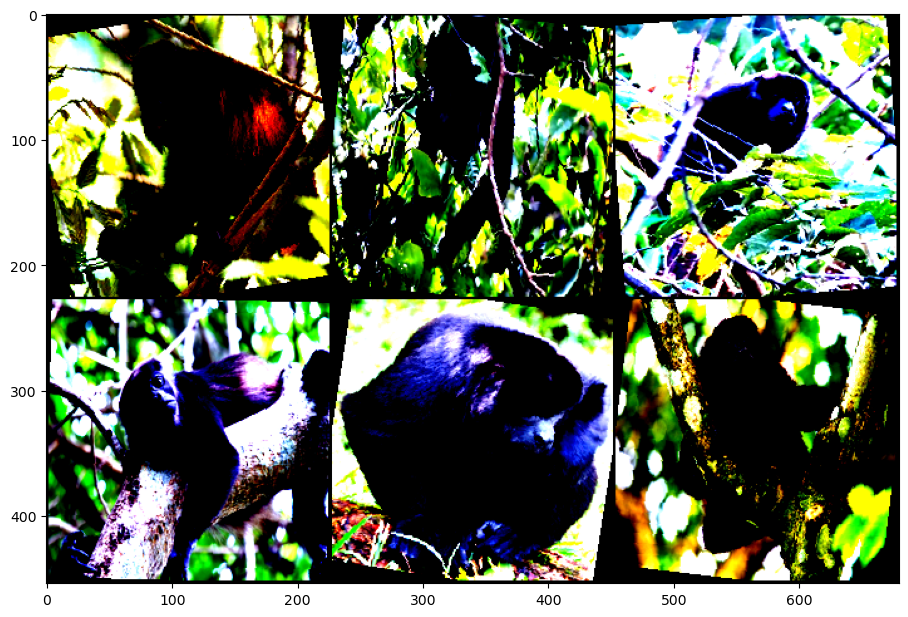

In [7]:
show_transformed_images(train_dataset)

In [8]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
def train_nn(model, train_loader, test_loader, criterion, optimizer, n_epochs):
    for epoch in range(n_epochs):
        model.train()
        running_loss = 0.0
        running_correct = 0.0
        total = 0

        for data in train_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)

            optimizer.zero_grad()
            outputs = model(images)

            _, predicted = torch.max(outputs.data, 1)

            loss = criterion(outputs, labels)

            loss.backward()

            optimizer.step()

            running_loss += loss.item()
            running_correct += (labels == predicted).sum().item()

        epoch_loss = running_loss/len(train_loader)
        epoch_acc = 100.00 * running_correct / total

        print("     - Training dataset. Got %d out of %d images correctly (%.3f%%). Epoch loss: %.3f"
            % (running_correct, total, epoch_acc, epoch_loss))

        evaluate_model_on_test_set(model, test_loader)

        print('Finished')
        return model


In [11]:
def evaluate_model_on_test_set(model, test_loader):
    print('yolo')

In [12]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

resnet18_model = models.resnet18(pretrained=False)
num_ftrs = resnet18_model.fc.in_features
number_of_classes = 10
resnet18_model.fc = nn.Linear(num_ftrs, number_of_classes)
resnet_18_model = resnet18_model.to(device)
loss_fn = nn.CrossEntropyLoss()

optimizer = optim.SGD(resnet18_model.parameters(),lr=0.01, momentum=0.9, weight_decay=0.003)

/home/sadam/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sadam/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [13]:
train_nn(resnet18_model, train_loader, test_loader, loss_fn, optimizer, 150)

yolo
